# Generative Adversial Network
In this problem we'll be trying to develop a GAN based on the CIFAR-10 Dataset

## Understanding Generative Adversarial Networks (GANs)

Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.

GANs were introduced in a paper by Ian Goodfellow and other researchers at the University of Montreal, including Yoshua Bengio, in 2014. Referring to GANs, Facebook’s AI research director Yann LeCun called adversarial training “the most interesting idea in the last 10 years in ML.”

GANs’ potential for both good and evil is huge, because they can learn to mimic any distribution of data. That is, GANs can be taught to create worlds eerily similar to our own in any domain: images, music, speech, prose. They are robot artists in a sense, and their output is impressive – poignant even. But they can also be used to generate fake media content, and are the technology underpinning Deepfakes.

## How GANs Work

One neural network, called the generator, generates new data instances, while the other, the discriminator, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data that it reviews belongs to the actual training dataset or not.

Let’s say we’re trying to do something more banal than mimic the Mona Lisa. We’re going to generate hand-written numerals like those found in the MNIST dataset, which is taken from the real world. The goal of the discriminator, when shown an instance from the true MNIST dataset, is to recognize those that are authentic.

Meanwhile, the generator is creating new, synthetic images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate passable hand-written digits: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.

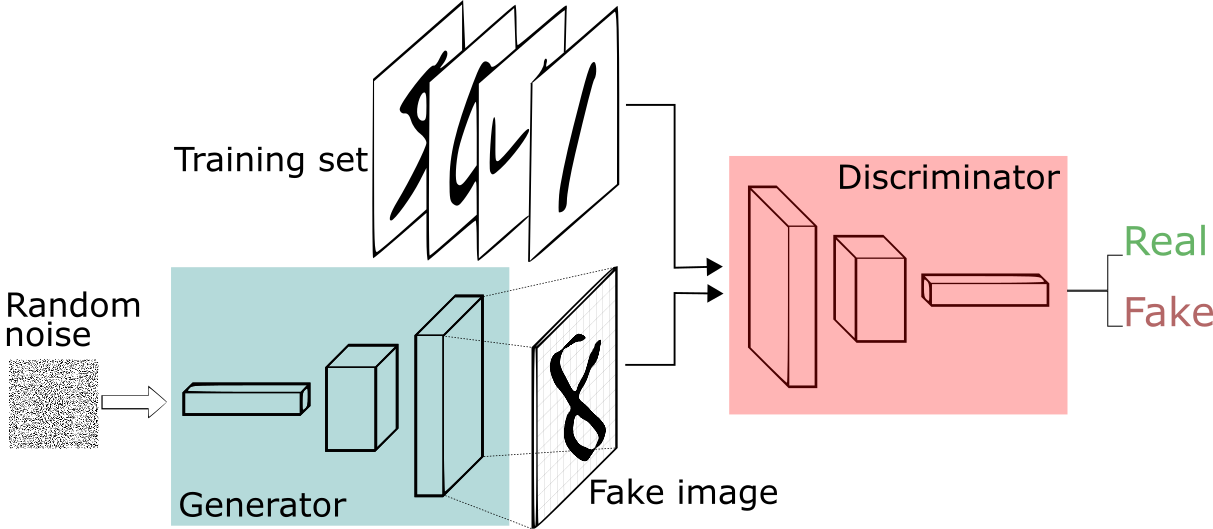
Here are the steps a GAN takes:

    The generator takes in random numbers and returns an image.
    This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground truth dataset.
    The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, 
    with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

    The discriminator is in a feedback loop with the ground truth of the images, which we know.
    The generator is in a feedback loop with the discriminator.


You can think of a GAN as the opposition of a counterfeiter and a cop in a game of cat and mouse, where the counterfeiter is learning to pass false notes, and the cop is learning to detect them. Both are dynamic; i.e. the cop is in training, too (to extend the analogy, maybe the central bank is flagging bills that slipped through), and each side comes to learn the other’s methods in a constant escalation.

For MNIST, the discriminator network is a standard convolutional network that can categorize the images fed to it, a binomial classifier labeling images as real or fake. The generator is an inverse convolutional network, in a sense: While a standard convolutional classifier takes an image and downsamples it to produce a probability, the generator takes a vector of random noise and upsamples it to an image. The first throws away data through downsampling techniques like maxpooling, and the second generates new data.

Both nets are trying to optimize a different and opposing objective function, or loss function, in a zero-zum game. This is essentially an actor-critic model. As the discriminator changes its behavior, so does the generator, and vice versa. Their losses push against each other.


 ## Actual Implementation

In [38]:
#importing necessary libraries
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot as plt
import tensorflow as tf

## Dataset preparation 
CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset (covered in the next section) by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

These are very small images, much smaller than a typical photograph, and the dataset is intended for computer vision research.

Keras provides access to the CIFAR10 dataset via the cifar10.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

In [33]:
(train_images, train_labels), (_, _) = load_data()

170508288/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


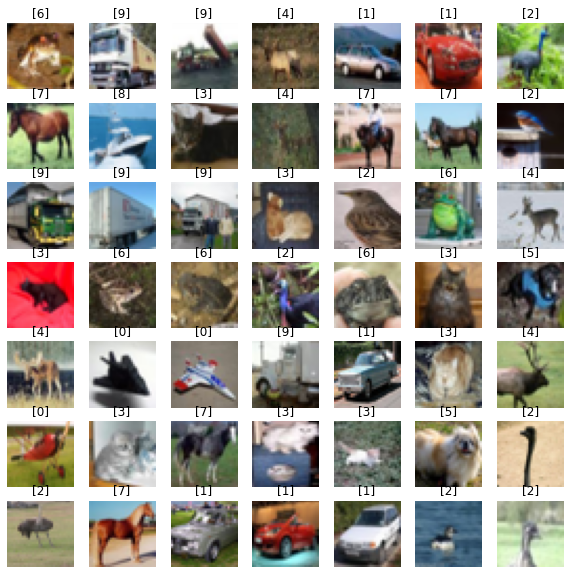

In [35]:
print(train_images.shape)
plt.figure(figsize=(10, 10))
for i in range(49):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])
    plt.axis("off")

In [43]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [44]:
print(train_images.shape)

(50000, 32, 32, 3)


## Creating the Generator architecture

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 32x32x3. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [39]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

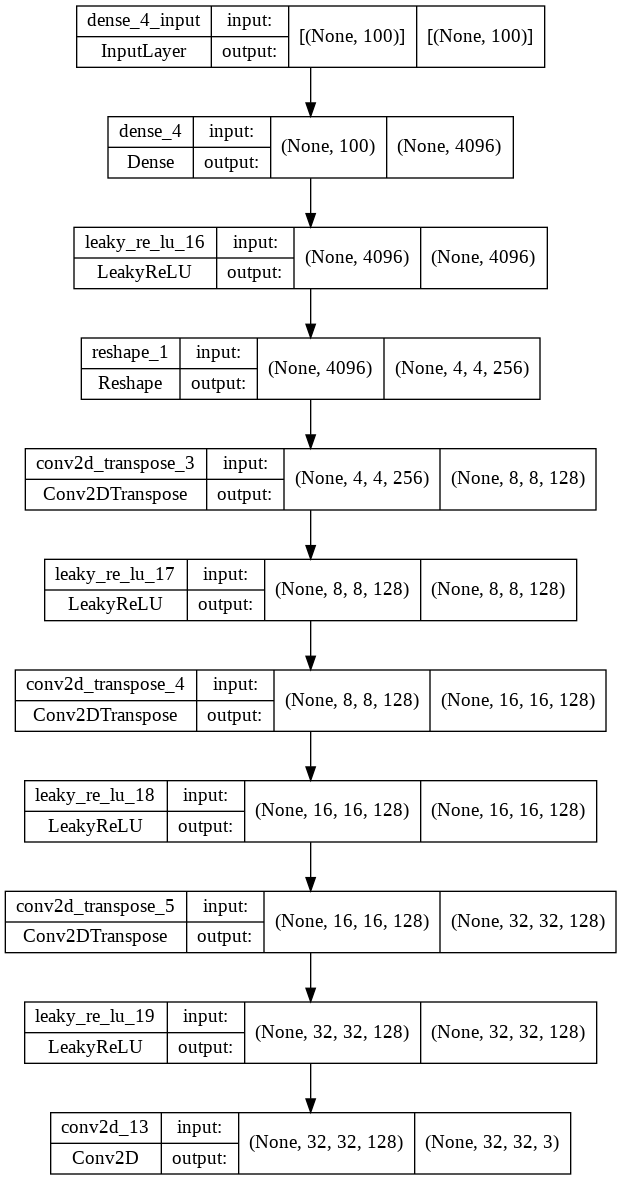

In [40]:
generator = define_generator(100)
generator.summary()
tf.keras.utils.plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

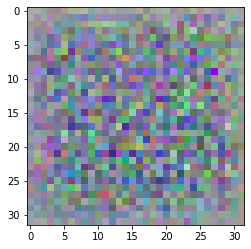

In [41]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
numpy_images = generated_image.numpy()
scaled_images = (((numpy_images - numpy_images.min()) * 255) / (numpy_images.max() - numpy_images.min())).astype(np.uint8)
plt.imshow(scaled_images[0])

## Building the Discriminator 
The discriminator will be a CNN classifier
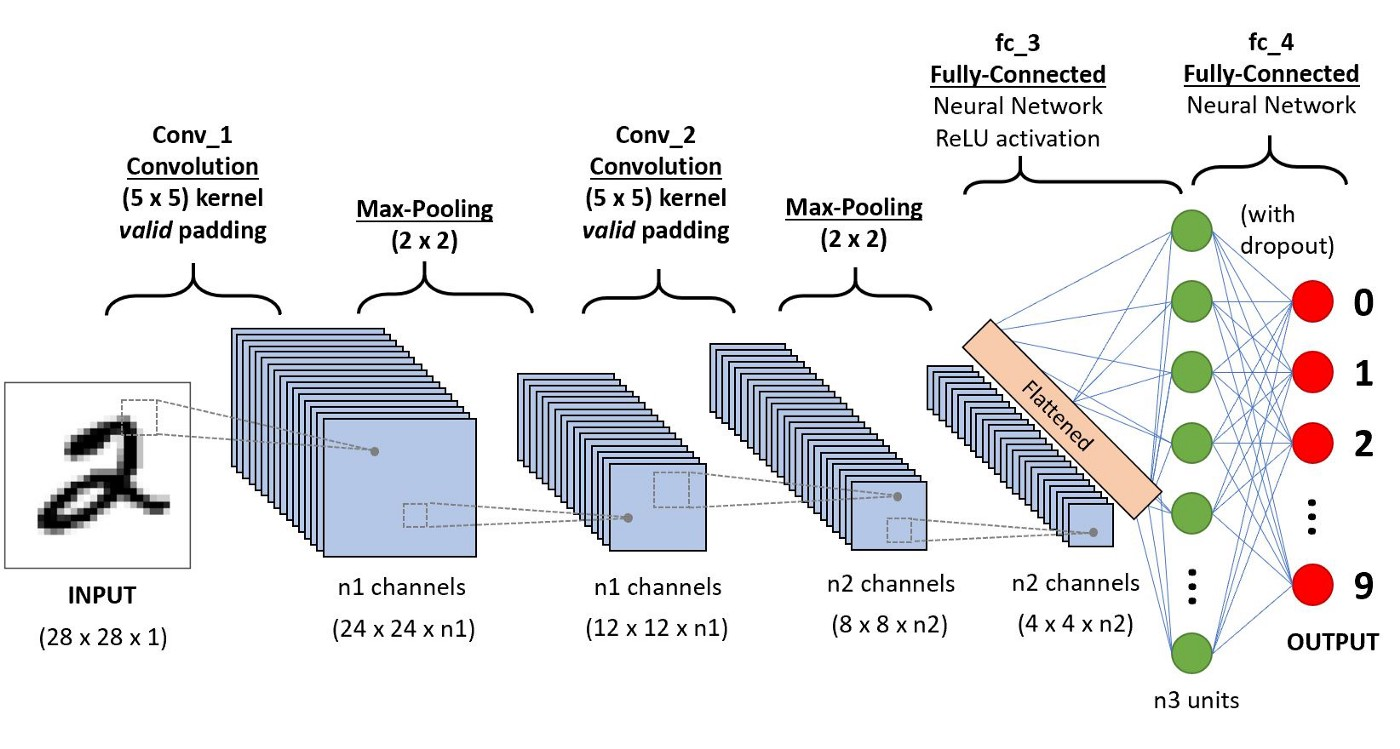
The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


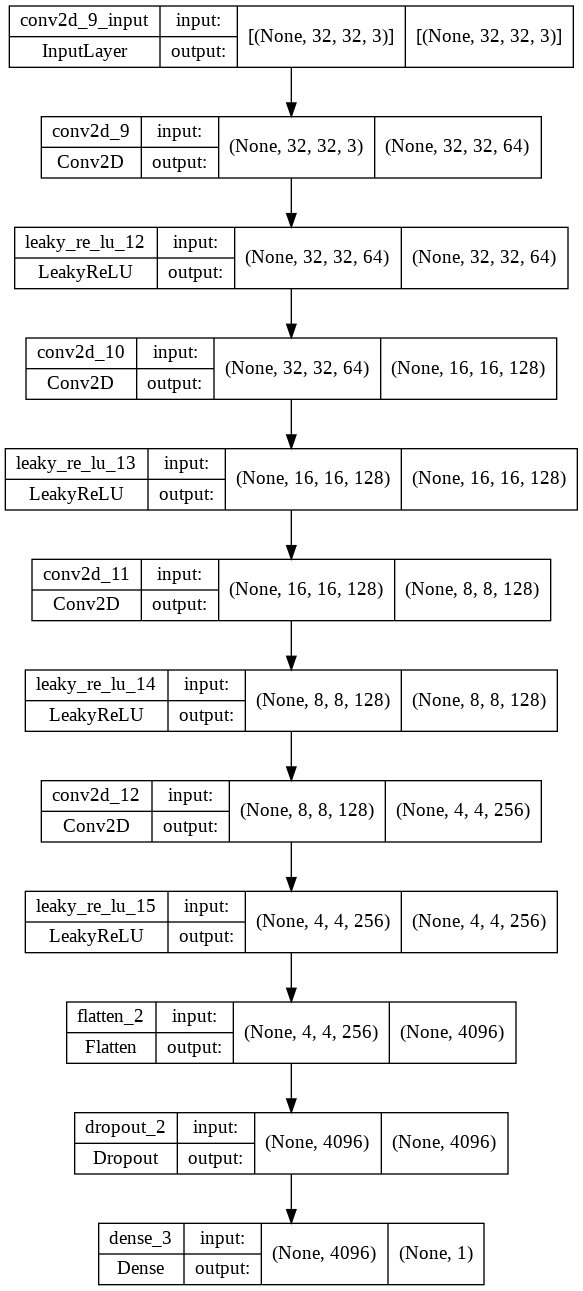

In [37]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define model
discriminator = define_discriminator()
# summarize the model
discriminator.summary()
# plot the model
tf.keras.utils.plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## GAN Definition
The function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

In [42]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Generating Real Samples
The function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [45]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

## Generating Latent space points
The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [46]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

## Generating Fake Samples
The function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [47]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

As we are evaluating the discriminator on 100 generated CIFAR-10 images, we can plot about half, or 49, as a 7 by 7 grid. The save_plot() function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [49]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

## Performance Measurement
we summarize the performance of the discriminator model. It does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR-10 images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample, and reporting these scores.

In [50]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [51]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [53]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = train_images
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/390, d1=0.690, d2=0.697 g=0.690
>1, 2/390, d1=0.623, d2=0.701 g=0.686
>1, 3/390, d1=0.549, d2=0.714 g=0.673
>1, 4/390, d1=0.448, d2=0.743 g=0.649
>1, 5/390, d1=0.329, d2=0.805 g=0.610
>1, 6/390, d1=0.261, d2=0.891 g=0.573
>1, 7/390, d1=0.219, d2=0.947 g=0.576
>1, 8/390, d1=0.186, d2=0.903 g=0.637
>1, 9/390, d1=0.215, d2=0.761 g=0.765
>1, 10/390, d1=0.177, d2=0.614 g=0.908
>1, 11/390, d1=0.147, d2=0.536 g=1.020
>1, 12/390, d1=0.157, d2=0.525 g=1.016
>1, 13/390, d1=0.112, d2=0.549 g=0.940
>1, 14/390, d1=0.103, d2=0.589 g=0.865
>1, 15/390, d1=0.313, d2=0.646 g=0.782
>1, 16/390, d1=0.139, d2=0.726 g=0.753
>1, 17/390, d1=0.155, d2=0.800 g=0.729
>1, 18/390, d1=0.157, d2=1.003 g=0.642
>1, 19/390, d1=0.216, d2=1.297 g=0.561
>1, 20/390, d1=0.148, d2=1.281 g=0.634
>1, 21/390, d1=0.255, d2=0.905 g=0.848
>1, 22/390, d1=0.309, d2=0.604 g=1.146
>1, 23/390, d1=0.341, d2=0.480 g=1.179
>1, 24/390, d1=0.309, d2=0.526 g=1.052
>1, 25/390, d1=0.242, d2=0.612 g=0.880
>1, 26/390, d1=0.124, d2=0.677 g=0

>11, 1/390, d1=0.672, d2=0.503 g=1.128
>11, 2/390, d1=0.653, d2=0.535 g=1.062
>11, 3/390, d1=0.679, d2=0.590 g=1.027
>11, 4/390, d1=0.650, d2=0.676 g=1.055
>11, 5/390, d1=0.667, d2=0.658 g=1.054
>11, 6/390, d1=0.581, d2=0.584 g=0.996
>11, 7/390, d1=0.624, d2=0.647 g=1.019
>11, 8/390, d1=0.610, d2=0.633 g=0.981
>11, 9/390, d1=0.644, d2=0.689 g=1.028
>11, 10/390, d1=0.663, d2=0.570 g=1.044
>11, 11/390, d1=0.678, d2=0.602 g=1.051
>11, 12/390, d1=0.630, d2=0.564 g=1.057
>11, 13/390, d1=0.591, d2=0.559 g=1.112
>11, 14/390, d1=0.563, d2=0.569 g=1.172
>11, 15/390, d1=0.618, d2=0.561 g=1.154
>11, 16/390, d1=0.756, d2=0.508 g=1.111
>11, 17/390, d1=0.583, d2=0.669 g=1.068
>11, 18/390, d1=0.573, d2=0.632 g=1.100
>11, 19/390, d1=0.762, d2=0.686 g=1.083
>11, 20/390, d1=0.740, d2=0.639 g=1.174
>11, 21/390, d1=0.754, d2=0.580 g=1.134
>11, 22/390, d1=0.634, d2=0.632 g=1.201
>11, 23/390, d1=0.742, d2=0.538 g=1.216
>11, 24/390, d1=0.716, d2=0.543 g=1.164
>11, 25/390, d1=0.645, d2=0.497 g=1.078
>11, 26/3

>21, 1/390, d1=0.712, d2=0.599 g=0.960
>21, 2/390, d1=0.710, d2=0.634 g=0.901
>21, 3/390, d1=0.774, d2=0.607 g=0.908
>21, 4/390, d1=0.721, d2=0.633 g=0.873
>21, 5/390, d1=0.646, d2=0.607 g=0.877
>21, 6/390, d1=0.697, d2=0.622 g=0.874
>21, 7/390, d1=0.702, d2=0.681 g=0.844
>21, 8/390, d1=0.731, d2=0.613 g=0.846
>21, 9/390, d1=0.707, d2=0.686 g=0.864
>21, 10/390, d1=0.668, d2=0.675 g=0.800
>21, 11/390, d1=0.678, d2=0.667 g=0.809
>21, 12/390, d1=0.696, d2=0.639 g=0.827
>21, 13/390, d1=0.680, d2=0.685 g=0.804
>21, 14/390, d1=0.716, d2=0.600 g=0.819
>21, 15/390, d1=0.637, d2=0.650 g=0.812
>21, 16/390, d1=0.618, d2=0.730 g=0.789
>21, 17/390, d1=0.640, d2=0.633 g=0.830
>21, 18/390, d1=0.625, d2=0.632 g=0.841
>21, 19/390, d1=0.608, d2=0.635 g=0.887
>21, 20/390, d1=0.645, d2=0.635 g=0.839
>21, 21/390, d1=0.658, d2=0.643 g=0.799
>21, 22/390, d1=0.657, d2=0.739 g=0.848
>21, 23/390, d1=0.735, d2=0.704 g=0.817
>21, 24/390, d1=0.654, d2=0.759 g=0.870
>21, 25/390, d1=0.711, d2=0.616 g=0.892
>21, 26/3

>31, 1/390, d1=0.666, d2=0.673 g=0.793
>31, 2/390, d1=0.678, d2=0.648 g=0.818
>31, 3/390, d1=0.637, d2=0.605 g=0.840
>31, 4/390, d1=0.705, d2=0.658 g=0.872
>31, 5/390, d1=0.654, d2=0.618 g=0.853
>31, 6/390, d1=0.695, d2=0.602 g=0.836
>31, 7/390, d1=0.628, d2=0.642 g=0.836
>31, 8/390, d1=0.681, d2=0.634 g=0.840
>31, 9/390, d1=0.683, d2=0.634 g=0.840
>31, 10/390, d1=0.630, d2=0.643 g=0.801
>31, 11/390, d1=0.664, d2=0.656 g=0.768
>31, 12/390, d1=0.627, d2=0.674 g=0.775
>31, 13/390, d1=0.600, d2=0.647 g=0.787
>31, 14/390, d1=0.670, d2=0.746 g=0.807
>31, 15/390, d1=0.639, d2=0.628 g=0.811
>31, 16/390, d1=0.665, d2=0.647 g=0.819
>31, 17/390, d1=0.633, d2=0.621 g=0.872
>31, 18/390, d1=0.638, d2=0.704 g=0.836
>31, 19/390, d1=0.648, d2=0.722 g=0.837
>31, 20/390, d1=0.647, d2=0.692 g=0.857
>31, 21/390, d1=0.657, d2=0.642 g=0.911
>31, 22/390, d1=0.671, d2=0.606 g=0.906
>31, 23/390, d1=0.639, d2=0.634 g=0.855
>31, 24/390, d1=0.663, d2=0.903 g=0.862
>31, 25/390, d1=0.672, d2=0.643 g=0.854
>31, 26/3

>41, 1/390, d1=0.630, d2=0.639 g=0.806
>41, 2/390, d1=0.676, d2=0.641 g=0.776
>41, 3/390, d1=0.700, d2=0.674 g=0.812
>41, 4/390, d1=0.633, d2=0.663 g=0.808
>41, 5/390, d1=0.665, d2=0.651 g=0.834
>41, 6/390, d1=0.623, d2=0.617 g=0.781
>41, 7/390, d1=0.669, d2=0.675 g=0.793
>41, 8/390, d1=0.638, d2=0.647 g=0.828
>41, 9/390, d1=0.659, d2=0.640 g=0.816
>41, 10/390, d1=0.656, d2=0.696 g=0.810
>41, 11/390, d1=0.655, d2=0.725 g=0.825
>41, 12/390, d1=0.627, d2=0.665 g=0.812
>41, 13/390, d1=0.652, d2=0.638 g=0.861
>41, 14/390, d1=0.658, d2=0.605 g=0.834
>41, 15/390, d1=0.631, d2=0.657 g=0.879
>41, 16/390, d1=0.715, d2=0.631 g=0.858
>41, 17/390, d1=0.605, d2=0.655 g=0.864
>41, 18/390, d1=0.608, d2=0.640 g=0.806
>41, 19/390, d1=0.653, d2=0.686 g=0.783
>41, 20/390, d1=0.691, d2=0.758 g=0.779
>41, 21/390, d1=0.645, d2=0.670 g=0.839
>41, 22/390, d1=0.655, d2=0.681 g=0.819
>41, 23/390, d1=0.679, d2=0.704 g=0.851
>41, 24/390, d1=0.684, d2=0.612 g=0.820
>41, 25/390, d1=0.656, d2=0.687 g=0.839
>41, 26/3

>51, 1/390, d1=0.628, d2=0.664 g=0.799
>51, 2/390, d1=0.635, d2=0.704 g=0.834
>51, 3/390, d1=0.614, d2=0.669 g=0.849
>51, 4/390, d1=0.646, d2=0.601 g=0.862
>51, 5/390, d1=0.634, d2=0.685 g=0.868
>51, 6/390, d1=0.652, d2=0.633 g=0.858
>51, 7/390, d1=0.626, d2=0.643 g=0.825
>51, 8/390, d1=0.631, d2=0.645 g=0.830
>51, 9/390, d1=0.667, d2=0.669 g=0.857
>51, 10/390, d1=0.649, d2=0.675 g=0.817
>51, 11/390, d1=0.645, d2=0.699 g=0.835
>51, 12/390, d1=0.655, d2=0.683 g=0.843
>51, 13/390, d1=0.670, d2=0.680 g=0.856
>51, 14/390, d1=0.710, d2=0.636 g=0.851
>51, 15/390, d1=0.694, d2=0.588 g=0.905
>51, 16/390, d1=0.659, d2=0.604 g=0.844
>51, 17/390, d1=0.621, d2=0.632 g=0.802
>51, 18/390, d1=0.642, d2=0.681 g=0.828
>51, 19/390, d1=0.642, d2=0.703 g=0.777
>51, 20/390, d1=0.633, d2=0.629 g=0.858
>51, 21/390, d1=0.658, d2=0.650 g=0.842
>51, 22/390, d1=0.713, d2=0.675 g=0.857
>51, 23/390, d1=0.689, d2=0.665 g=0.847
>51, 24/390, d1=0.626, d2=0.618 g=0.842
>51, 25/390, d1=0.641, d2=0.648 g=0.847
>51, 26/3

>61, 1/390, d1=0.596, d2=0.699 g=0.929
>61, 2/390, d1=0.682, d2=0.585 g=0.882
>61, 3/390, d1=0.685, d2=0.593 g=0.899
>61, 4/390, d1=0.631, d2=0.659 g=0.881
>61, 5/390, d1=0.667, d2=0.624 g=0.895
>61, 6/390, d1=0.644, d2=0.675 g=0.874
>61, 7/390, d1=0.632, d2=0.674 g=0.886
>61, 8/390, d1=0.627, d2=0.589 g=0.884
>61, 9/390, d1=0.591, d2=0.575 g=0.875
>61, 10/390, d1=0.663, d2=0.723 g=0.852
>61, 11/390, d1=0.631, d2=0.596 g=0.872
>61, 12/390, d1=0.657, d2=0.607 g=0.851
>61, 13/390, d1=0.635, d2=0.620 g=0.825
>61, 14/390, d1=0.670, d2=0.655 g=0.912
>61, 15/390, d1=0.631, d2=0.676 g=0.902
>61, 16/390, d1=0.663, d2=0.609 g=0.878
>61, 17/390, d1=0.617, d2=0.669 g=0.900
>61, 18/390, d1=0.687, d2=0.579 g=0.914
>61, 19/390, d1=0.676, d2=0.645 g=0.872
>61, 20/390, d1=0.610, d2=0.666 g=0.825
>61, 21/390, d1=0.630, d2=0.730 g=0.872
>61, 22/390, d1=0.622, d2=0.638 g=0.908
>61, 23/390, d1=0.662, d2=0.636 g=0.899
>61, 24/390, d1=0.669, d2=0.623 g=0.865
>61, 25/390, d1=0.707, d2=0.614 g=0.863
>61, 26/3

>71, 1/390, d1=0.675, d2=0.691 g=0.926
>71, 2/390, d1=0.709, d2=0.641 g=0.882
>71, 3/390, d1=0.670, d2=0.662 g=0.888
>71, 4/390, d1=0.684, d2=0.567 g=0.865
>71, 5/390, d1=0.672, d2=0.624 g=0.888
>71, 6/390, d1=0.613, d2=0.696 g=0.910
>71, 7/390, d1=0.630, d2=0.677 g=0.889
>71, 8/390, d1=0.585, d2=0.658 g=0.895
>71, 9/390, d1=0.602, d2=0.551 g=0.855
>71, 10/390, d1=0.697, d2=0.612 g=0.923
>71, 11/390, d1=0.710, d2=0.594 g=0.912
>71, 12/390, d1=0.591, d2=0.679 g=0.904
>71, 13/390, d1=0.657, d2=0.666 g=0.897
>71, 14/390, d1=0.654, d2=0.640 g=0.914
>71, 15/390, d1=0.688, d2=0.589 g=0.937
>71, 16/390, d1=0.680, d2=0.598 g=0.926
>71, 17/390, d1=0.648, d2=0.619 g=0.878
>71, 18/390, d1=0.643, d2=0.620 g=0.884
>71, 19/390, d1=0.577, d2=0.645 g=0.878
>71, 20/390, d1=0.653, d2=0.629 g=0.852
>71, 21/390, d1=0.649, d2=0.612 g=0.930
>71, 22/390, d1=0.608, d2=0.556 g=0.838
>71, 23/390, d1=0.624, d2=0.623 g=0.859
>71, 24/390, d1=0.659, d2=0.572 g=0.936
>71, 25/390, d1=0.673, d2=0.567 g=0.907
>71, 26/3

>81, 1/390, d1=0.586, d2=0.489 g=0.937
>81, 2/390, d1=0.671, d2=0.631 g=0.958
>81, 3/390, d1=0.666, d2=0.602 g=0.921
>81, 4/390, d1=0.627, d2=0.641 g=0.988
>81, 5/390, d1=0.759, d2=0.583 g=0.959
>81, 6/390, d1=0.648, d2=0.625 g=0.972
>81, 7/390, d1=0.596, d2=0.582 g=0.977
>81, 8/390, d1=0.652, d2=0.602 g=0.950
>81, 9/390, d1=0.656, d2=0.710 g=0.945
>81, 10/390, d1=0.650, d2=0.607 g=0.912
>81, 11/390, d1=0.657, d2=0.644 g=0.895
>81, 12/390, d1=0.637, d2=0.725 g=0.907
>81, 13/390, d1=0.646, d2=0.573 g=0.954
>81, 14/390, d1=0.617, d2=0.630 g=1.040
>81, 15/390, d1=0.692, d2=0.569 g=0.976
>81, 16/390, d1=0.628, d2=0.600 g=0.983
>81, 17/390, d1=0.653, d2=0.575 g=0.954
>81, 18/390, d1=0.668, d2=0.620 g=0.948
>81, 19/390, d1=0.572, d2=0.671 g=0.987
>81, 20/390, d1=0.580, d2=0.596 g=0.953
>81, 21/390, d1=0.749, d2=0.584 g=0.979
>81, 22/390, d1=0.651, d2=0.687 g=0.995
>81, 23/390, d1=0.649, d2=0.551 g=0.891
>81, 24/390, d1=0.610, d2=0.607 g=0.927
>81, 25/390, d1=0.615, d2=0.560 g=0.978
>81, 26/3

>91, 1/390, d1=0.616, d2=0.607 g=0.968
>91, 2/390, d1=0.672, d2=0.632 g=0.950
>91, 3/390, d1=0.655, d2=0.556 g=0.938
>91, 4/390, d1=0.640, d2=0.606 g=0.940
>91, 5/390, d1=0.537, d2=0.664 g=0.954
>91, 6/390, d1=0.585, d2=0.681 g=1.013
>91, 7/390, d1=0.655, d2=0.533 g=0.888
>91, 8/390, d1=0.612, d2=0.560 g=0.996
>91, 9/390, d1=0.654, d2=0.562 g=1.020
>91, 10/390, d1=0.607, d2=0.614 g=0.943
>91, 11/390, d1=0.625, d2=0.659 g=0.946
>91, 12/390, d1=0.556, d2=0.574 g=1.036
>91, 13/390, d1=0.607, d2=0.609 g=0.914
>91, 14/390, d1=0.694, d2=0.586 g=0.927
>91, 15/390, d1=0.621, d2=0.586 g=0.962
>91, 16/390, d1=0.579, d2=0.590 g=0.978
>91, 17/390, d1=0.559, d2=0.628 g=0.981
>91, 18/390, d1=0.610, d2=0.602 g=0.995
>91, 19/390, d1=0.563, d2=0.508 g=0.964
>91, 20/390, d1=0.705, d2=0.654 g=0.989
>91, 21/390, d1=0.580, d2=0.663 g=0.899
>91, 22/390, d1=0.652, d2=0.671 g=0.997
>91, 23/390, d1=0.603, d2=0.628 g=1.025
>91, 24/390, d1=0.597, d2=0.581 g=1.080
>91, 25/390, d1=0.711, d2=0.589 g=1.061
>91, 26/3

>101, 1/390, d1=0.512, d2=0.622 g=1.053
>101, 2/390, d1=0.627, d2=0.541 g=1.122
>101, 3/390, d1=0.663, d2=0.612 g=1.124
>101, 4/390, d1=0.582, d2=0.536 g=1.092
>101, 5/390, d1=0.700, d2=0.554 g=1.052
>101, 6/390, d1=0.578, d2=0.576 g=1.076
>101, 7/390, d1=0.698, d2=0.657 g=1.022
>101, 8/390, d1=0.661, d2=0.593 g=1.018
>101, 9/390, d1=0.612, d2=0.578 g=0.977
>101, 10/390, d1=0.613, d2=0.554 g=1.004
>101, 11/390, d1=0.581, d2=0.531 g=1.024
>101, 12/390, d1=0.621, d2=0.620 g=0.978
>101, 13/390, d1=0.670, d2=0.636 g=0.958
>101, 14/390, d1=0.647, d2=0.658 g=0.976
>101, 15/390, d1=0.543, d2=0.625 g=0.955
>101, 16/390, d1=0.618, d2=0.664 g=0.990
>101, 17/390, d1=0.582, d2=0.688 g=1.039
>101, 18/390, d1=0.631, d2=0.578 g=1.003
>101, 19/390, d1=0.616, d2=0.641 g=1.012
>101, 20/390, d1=0.667, d2=0.594 g=0.984
>101, 21/390, d1=0.671, d2=0.560 g=1.014
>101, 22/390, d1=0.573, d2=0.618 g=1.049
>101, 23/390, d1=0.585, d2=0.571 g=1.065
>101, 24/390, d1=0.729, d2=0.549 g=1.006
>101, 25/390, d1=0.664, d

>111, 1/390, d1=0.577, d2=0.566 g=1.093
>111, 2/390, d1=0.647, d2=0.525 g=1.038
>111, 3/390, d1=0.616, d2=0.527 g=1.020
>111, 4/390, d1=0.614, d2=0.541 g=0.991
>111, 5/390, d1=0.577, d2=0.620 g=1.050
>111, 6/390, d1=0.605, d2=0.583 g=1.039
>111, 7/390, d1=0.599, d2=0.587 g=1.038
>111, 8/390, d1=0.561, d2=0.652 g=1.026
>111, 9/390, d1=0.566, d2=0.585 g=1.008
>111, 10/390, d1=0.612, d2=0.549 g=0.982
>111, 11/390, d1=0.678, d2=0.579 g=1.048
>111, 12/390, d1=0.644, d2=0.594 g=1.076
>111, 13/390, d1=0.615, d2=0.652 g=1.051
>111, 14/390, d1=0.599, d2=0.645 g=0.963
>111, 15/390, d1=0.634, d2=0.630 g=1.084
>111, 16/390, d1=0.577, d2=0.566 g=1.095
>111, 17/390, d1=0.634, d2=0.521 g=1.116
>111, 18/390, d1=0.594, d2=0.546 g=1.091
>111, 19/390, d1=0.512, d2=0.602 g=0.997
>111, 20/390, d1=0.649, d2=0.584 g=1.011
>111, 21/390, d1=0.610, d2=0.597 g=1.033
>111, 22/390, d1=0.762, d2=0.683 g=0.972
>111, 23/390, d1=0.650, d2=0.677 g=1.058
>111, 24/390, d1=0.536, d2=0.643 g=1.097
>111, 25/390, d1=0.613, d

>121, 1/390, d1=0.604, d2=0.537 g=1.090
>121, 2/390, d1=0.537, d2=0.705 g=1.187
>121, 3/390, d1=0.653, d2=0.491 g=1.171
>121, 4/390, d1=0.598, d2=0.570 g=1.084
>121, 5/390, d1=0.685, d2=0.569 g=1.125
>121, 6/390, d1=0.569, d2=0.490 g=1.105
>121, 7/390, d1=0.653, d2=0.588 g=1.037
>121, 8/390, d1=0.570, d2=0.611 g=1.088
>121, 9/390, d1=0.613, d2=0.554 g=1.114
>121, 10/390, d1=0.605, d2=0.495 g=1.183
>121, 11/390, d1=0.577, d2=0.548 g=1.078
>121, 12/390, d1=0.571, d2=0.686 g=1.240
>121, 13/390, d1=0.580, d2=0.459 g=1.108
>121, 14/390, d1=0.677, d2=0.603 g=1.055
>121, 15/390, d1=0.559, d2=0.517 g=1.130
>121, 16/390, d1=0.514, d2=0.681 g=1.132
>121, 17/390, d1=0.737, d2=0.555 g=1.087
>121, 18/390, d1=0.607, d2=0.592 g=1.132
>121, 19/390, d1=0.514, d2=0.537 g=1.142
>121, 20/390, d1=0.644, d2=0.600 g=1.025
>121, 21/390, d1=0.645, d2=0.612 g=1.037
>121, 22/390, d1=0.624, d2=0.556 g=1.111
>121, 23/390, d1=0.590, d2=0.591 g=1.097
>121, 24/390, d1=0.599, d2=0.515 g=1.030
>121, 25/390, d1=0.600, d

>131, 1/390, d1=0.655, d2=0.560 g=1.180
>131, 2/390, d1=0.531, d2=0.564 g=1.213
>131, 3/390, d1=0.557, d2=0.560 g=1.163
>131, 4/390, d1=0.579, d2=0.458 g=1.124
>131, 5/390, d1=0.583, d2=0.562 g=1.237
>131, 6/390, d1=0.715, d2=0.559 g=1.071
>131, 7/390, d1=0.514, d2=0.532 g=1.136
>131, 8/390, d1=0.501, d2=0.639 g=1.099
>131, 9/390, d1=0.639, d2=0.583 g=1.143
>131, 10/390, d1=0.609, d2=0.553 g=1.092
>131, 11/390, d1=0.554, d2=0.578 g=1.199
>131, 12/390, d1=0.726, d2=0.479 g=1.171
>131, 13/390, d1=0.517, d2=0.693 g=1.182
>131, 14/390, d1=0.533, d2=0.521 g=1.278
>131, 15/390, d1=0.650, d2=0.627 g=1.134
>131, 16/390, d1=0.547, d2=0.515 g=1.176
>131, 17/390, d1=0.578, d2=0.481 g=1.177
>131, 18/390, d1=0.600, d2=0.447 g=1.234
>131, 19/390, d1=0.511, d2=0.621 g=1.166
>131, 20/390, d1=0.569, d2=0.509 g=1.160
>131, 21/390, d1=0.477, d2=0.549 g=1.126
>131, 22/390, d1=0.625, d2=0.567 g=1.083
>131, 23/390, d1=0.546, d2=0.548 g=1.143
>131, 24/390, d1=0.629, d2=0.601 g=1.250
>131, 25/390, d1=0.491, d

>141, 1/390, d1=0.584, d2=0.536 g=1.227
>141, 2/390, d1=0.605, d2=0.638 g=1.219
>141, 3/390, d1=0.468, d2=0.527 g=1.264
>141, 4/390, d1=0.674, d2=0.519 g=1.185
>141, 5/390, d1=0.523, d2=0.588 g=1.284
>141, 6/390, d1=0.632, d2=0.431 g=1.185
>141, 7/390, d1=0.569, d2=0.544 g=1.243
>141, 8/390, d1=0.593, d2=0.504 g=1.310
>141, 9/390, d1=0.526, d2=0.483 g=1.246
>141, 10/390, d1=0.615, d2=0.509 g=1.195
>141, 11/390, d1=0.519, d2=0.601 g=1.168
>141, 12/390, d1=0.532, d2=0.618 g=1.215
>141, 13/390, d1=0.457, d2=0.502 g=1.253
>141, 14/390, d1=0.584, d2=0.496 g=1.202
>141, 15/390, d1=0.573, d2=0.541 g=1.319
>141, 16/390, d1=0.480, d2=0.493 g=1.243
>141, 17/390, d1=0.568, d2=0.426 g=1.302
>141, 18/390, d1=0.595, d2=0.674 g=1.304
>141, 19/390, d1=0.622, d2=0.589 g=1.298
>141, 20/390, d1=0.681, d2=0.543 g=1.309
>141, 21/390, d1=0.648, d2=0.512 g=1.157
>141, 22/390, d1=0.595, d2=0.496 g=1.089
>141, 23/390, d1=0.529, d2=0.524 g=1.170
>141, 24/390, d1=0.629, d2=0.468 g=1.148
>141, 25/390, d1=0.539, d

>151, 1/390, d1=0.567, d2=0.560 g=1.266
>151, 2/390, d1=0.524, d2=0.487 g=1.288
>151, 3/390, d1=0.513, d2=0.661 g=1.255
>151, 4/390, d1=0.526, d2=0.501 g=1.292
>151, 5/390, d1=0.688, d2=0.507 g=1.291
>151, 6/390, d1=0.626, d2=0.496 g=1.316
>151, 7/390, d1=0.469, d2=0.490 g=1.314
>151, 8/390, d1=0.540, d2=0.492 g=1.322
>151, 9/390, d1=0.521, d2=0.567 g=1.315
>151, 10/390, d1=0.594, d2=0.515 g=1.485
>151, 11/390, d1=0.640, d2=0.569 g=1.342
>151, 12/390, d1=0.617, d2=0.522 g=1.287
>151, 13/390, d1=0.592, d2=0.510 g=1.290
>151, 14/390, d1=0.679, d2=0.479 g=1.226
>151, 15/390, d1=0.556, d2=0.568 g=1.312
>151, 16/390, d1=0.553, d2=0.511 g=1.148
>151, 17/390, d1=0.448, d2=0.523 g=1.393
>151, 18/390, d1=0.589, d2=0.442 g=1.178
>151, 19/390, d1=0.623, d2=0.567 g=1.141
>151, 20/390, d1=0.575, d2=0.618 g=1.252
>151, 21/390, d1=0.580, d2=0.519 g=1.292
>151, 22/390, d1=0.651, d2=0.435 g=1.317
>151, 23/390, d1=0.488, d2=0.516 g=1.235
>151, 24/390, d1=0.658, d2=0.618 g=1.119
>151, 25/390, d1=0.542, d

>161, 1/390, d1=0.493, d2=0.620 g=1.444
>161, 2/390, d1=0.671, d2=0.422 g=1.309
>161, 3/390, d1=0.818, d2=0.541 g=1.347
>161, 4/390, d1=0.515, d2=0.514 g=1.302
>161, 5/390, d1=0.516, d2=0.479 g=1.315
>161, 6/390, d1=0.458, d2=0.610 g=1.354
>161, 7/390, d1=0.580, d2=0.472 g=1.390
>161, 8/390, d1=0.581, d2=0.481 g=1.353
>161, 9/390, d1=0.642, d2=0.501 g=1.259
>161, 10/390, d1=0.446, d2=0.584 g=1.274
>161, 11/390, d1=0.531, d2=0.518 g=1.362
>161, 12/390, d1=0.559, d2=0.618 g=1.327
>161, 13/390, d1=0.531, d2=0.518 g=1.417
>161, 14/390, d1=0.527, d2=0.567 g=1.301
>161, 15/390, d1=0.647, d2=0.434 g=1.345
>161, 16/390, d1=0.550, d2=0.448 g=1.369
>161, 17/390, d1=0.610, d2=0.483 g=1.219
>161, 18/390, d1=0.424, d2=0.411 g=1.196
>161, 19/390, d1=0.536, d2=0.562 g=1.244
>161, 20/390, d1=0.423, d2=0.505 g=1.268
>161, 21/390, d1=0.488, d2=0.549 g=1.321
>161, 22/390, d1=0.668, d2=0.481 g=1.397
>161, 23/390, d1=0.532, d2=0.501 g=1.377
>161, 24/390, d1=0.491, d2=0.419 g=1.219
>161, 25/390, d1=0.551, d

>171, 1/390, d1=0.623, d2=0.573 g=1.382
>171, 2/390, d1=0.379, d2=0.472 g=1.360
>171, 3/390, d1=0.611, d2=0.424 g=1.507
>171, 4/390, d1=0.489, d2=0.367 g=1.433
>171, 5/390, d1=0.561, d2=0.600 g=1.326
>171, 6/390, d1=0.528, d2=0.431 g=1.335
>171, 7/390, d1=0.418, d2=0.529 g=1.309
>171, 8/390, d1=0.464, d2=0.468 g=1.462
>171, 9/390, d1=0.523, d2=0.489 g=1.436
>171, 10/390, d1=0.455, d2=0.462 g=1.439
>171, 11/390, d1=0.546, d2=0.617 g=1.371
>171, 12/390, d1=0.501, d2=0.409 g=1.597
>171, 13/390, d1=0.753, d2=0.397 g=1.466
>171, 14/390, d1=0.590, d2=0.505 g=1.400
>171, 15/390, d1=0.583, d2=0.555 g=1.373
>171, 16/390, d1=0.610, d2=0.583 g=1.392
>171, 17/390, d1=0.469, d2=0.458 g=1.446
>171, 18/390, d1=0.575, d2=0.417 g=1.359
>171, 19/390, d1=0.574, d2=0.501 g=1.400
>171, 20/390, d1=0.401, d2=0.496 g=1.382
>171, 21/390, d1=0.500, d2=0.468 g=1.440
>171, 22/390, d1=0.540, d2=0.448 g=1.368
>171, 23/390, d1=0.588, d2=0.505 g=1.285
>171, 24/390, d1=0.450, d2=0.563 g=1.352
>171, 25/390, d1=0.535, d

>181, 1/390, d1=0.534, d2=0.353 g=1.389
>181, 2/390, d1=0.520, d2=0.549 g=1.463
>181, 3/390, d1=0.514, d2=0.338 g=1.381
>181, 4/390, d1=0.453, d2=0.844 g=1.320
>181, 5/390, d1=0.522, d2=0.567 g=1.590
>181, 6/390, d1=0.660, d2=0.428 g=1.479
>181, 7/390, d1=0.613, d2=0.436 g=1.458
>181, 8/390, d1=0.484, d2=0.621 g=1.480
>181, 9/390, d1=0.616, d2=0.499 g=1.504
>181, 10/390, d1=0.633, d2=0.444 g=1.533
>181, 11/390, d1=0.525, d2=0.446 g=1.303
>181, 12/390, d1=0.475, d2=0.377 g=1.362
>181, 13/390, d1=0.389, d2=0.649 g=1.358
>181, 14/390, d1=0.539, d2=0.512 g=1.424
>181, 15/390, d1=0.493, d2=0.435 g=1.515
>181, 16/390, d1=0.424, d2=0.464 g=1.400
>181, 17/390, d1=0.554, d2=0.422 g=1.368
>181, 18/390, d1=0.612, d2=0.495 g=1.446
>181, 19/390, d1=0.406, d2=0.680 g=1.526
>181, 20/390, d1=0.625, d2=0.485 g=1.546
>181, 21/390, d1=0.532, d2=0.513 g=1.414
>181, 22/390, d1=0.631, d2=0.507 g=1.437
>181, 23/390, d1=0.526, d2=0.542 g=1.456
>181, 24/390, d1=0.491, d2=0.464 g=1.443
>181, 25/390, d1=0.488, d

>191, 1/390, d1=0.468, d2=0.436 g=1.562
>191, 2/390, d1=0.569, d2=0.395 g=1.422
>191, 3/390, d1=0.443, d2=0.613 g=1.427
>191, 4/390, d1=0.456, d2=0.500 g=1.462
>191, 5/390, d1=0.426, d2=0.323 g=1.436
>191, 6/390, d1=0.517, d2=0.494 g=1.539
>191, 7/390, d1=0.541, d2=0.514 g=1.478
>191, 8/390, d1=0.530, d2=0.466 g=1.484
>191, 9/390, d1=0.497, d2=0.437 g=1.514
>191, 10/390, d1=0.518, d2=0.442 g=1.302
>191, 11/390, d1=0.488, d2=0.498 g=1.555
>191, 12/390, d1=0.508, d2=0.426 g=1.589
>191, 13/390, d1=0.619, d2=0.408 g=1.566
>191, 14/390, d1=0.450, d2=0.453 g=1.376
>191, 15/390, d1=0.516, d2=0.438 g=1.432
>191, 16/390, d1=0.538, d2=0.425 g=1.343
>191, 17/390, d1=0.530, d2=0.474 g=1.362
>191, 18/390, d1=0.579, d2=0.398 g=1.338
>191, 19/390, d1=0.531, d2=0.426 g=1.374
>191, 20/390, d1=0.537, d2=0.560 g=1.376
>191, 21/390, d1=0.489, d2=0.433 g=1.435
>191, 22/390, d1=0.504, d2=0.476 g=1.367
>191, 23/390, d1=0.521, d2=0.665 g=1.380
>191, 24/390, d1=0.496, d2=0.673 g=1.385
>191, 25/390, d1=0.695, d

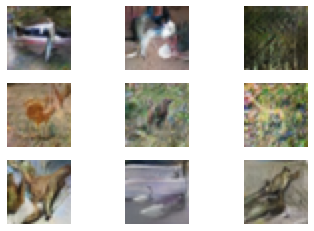

In [1]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 3)

Once a final generator model is selected, it can be used in a standalone manner for your application.
This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input.
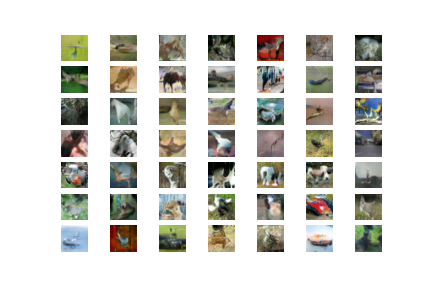
In this case, we used the model saved after 200 training epochs, but the model saved after 100 epochs would work just as well.